In [3]:
import os
import sys
import pandas as pd
import numpy as np
from chspy import CubicHermiteSpline
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, argrelextrema
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
import scienceplots

# Get the path of the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import importlib
import assistive_arm.utils.parametrize_profiles_functions
importlib.reload(assistive_arm.utils.parametrize_profiles_functions)
from assistive_arm.utils.parametrize_profiles_functions import *

# This script was used to come up with the parametrization used in the bayesian optimization

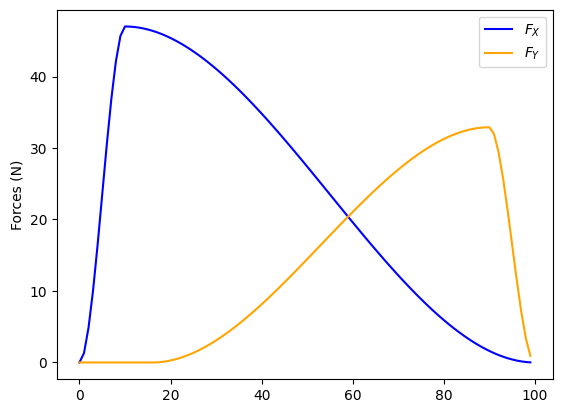

In [ ]:
force1_end_time_p = 0
force1_peak_force_p = 1.0

force2_start_time_p = 0.2
force2_peak_time_p = 1.0
force2_end_time_p = 1.0
force2_peak_force_p = 0.7


# Added profile
# force1_end_time_p = 0.8
# force1_peak_force_p = 1.0

# force2_start_time_p = 0.2
# force2_peak_time_p = 0.65
# force2_end_time_p = 1.0
# force2_peak_force_p = 0.7


# force1_end_time_p = 0.5
# force1_peak_force_p = 0.5

# force2_start_time_p = 0.2
# force2_peak_time_p = 0.5
# force2_end_time_p = 1.0
# force2_peak_force_p = 0.9



# force1_end_time_p = 0.8
# force1_peak_force_p = 1.0

# force2_start_time_p = 0.2
# force2_peak_time_p = 0.7
# force2_end_time_p = 1.0
# force2_peak_force_p = 0.4


force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time = percentage_to_actual_2(force1_end_time_p, force1_peak_force_p, force2_start_time_p, force2_peak_time_p, force2_peak_force_p, force2_end_time_p, 100)

# base_profile = get_profile(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time, 100)
base_profile = get_profile_2(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time, 100)

plot_force_profile(base_profile, None, None)

# save as CSV
# base_profile.to_csv("force_profile.csv", index=False)

### TESTING

In [14]:
# Load csv files
csv_path = f"/Users/nathanirniger/Desktop/profiles"

csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

sampling_frequency = 2148.259
profile_dict = {}

for csv_file in csv_files:
    df = pd.read_csv(f"{csv_path}/{csv_file}")
    relevant_columns = ["force_X", "force_Y"]
    df = df[relevant_columns]
    # Create a time column
    df["Time"] = np.linspace(0, len(df)/sampling_frequency, len(df))
    profile_dict[csv_file] = df

In [137]:
def parametrized_force_curve(t, t_start, t_end, t_peak, peakforce):
    # Piecewise segments:
    # 1. Initial segment (t < t_start): force = 0
    # 2. Rising part (t_start <= t <= t_peak): A smooth rising curve
    # 3. Falling part (t_peak < t <= t_end): A smooth decreasing curve
    
    result = np.zeros_like(t)
    
    # Rising segment (e.g., a quadratic rise)
    rise_mask = (t >= t_start) & (t <= t_peak)
    # result[rise_mask] = peakforce * ((t[rise_mask] - t_start) / (t_peak - t_start))**2
    result[rise_mask] = peakforce * (1 - ((t_peak - t[rise_mask]) / (t_peak - t_start))**2)

    # Falling segment (e.g., a quadratic fall)
    fall_mask = (t > t_peak) & (t <= t_end)
    result[fall_mask] = peakforce * (1 - ((t[fall_mask] - t_peak) / (t_end - t_peak))**2)
    
    return result, "quadratic1"


In [139]:
def quadratic_spline_piece(t, t0, t1, y0, y1, d):
    """
    Compute a single quadratic spline piece.
    t0, t1: time interval
    y0, y1: function values at interval endpoints
    d: derivative at t0
    """
    h = t1 - t0
    a = (y1 - y0 - d*h) / (h*h)
    b = d
    c = y0
    
    tau = (t - t0)
    return a * tau * tau + b * tau + c

def parametrized_force_curve(t, t_start, t_end, t_peak, f_peak):
    """
    Create a parametrized force curve using quadratic splines.
    """
    t = np.array(t)
    result = np.zeros_like(t, dtype=float)
    
    # Split the interval into four pieces
    t_points = [
        t_start,
        t_start + (t_peak - t_start) * 0.5,  # mid-rise
        t_peak,
        t_peak + (t_end - t_peak) * 0.5,     # mid-fall
        t_end
    ]
    
    # Function values at the points
    f_points = [0, f_peak * 0.5, f_peak, f_peak * 0.5, 0]
    
    # Define derivatives at the junction points
    # Start with zero derivative, rise to peak, then fall to zero
    d_start = 0
    d_midrise = 2 * f_peak / (t_peak - t_start)  # steeper slope during rise
    d_peak = 0  # zero derivative at peak
    d_midfall = -2 * f_peak / (t_end - t_peak)  # steeper slope during fall
    d_end = 0
    
    derivatives = [d_start, d_midrise, d_peak, d_midfall, d_end]
    
    # Compute each piece
    for i in range(len(t_points)-1):
        t0, t1 = t_points[i], t_points[i+1]
        y0, y1 = f_points[i], f_points[i+1]
        d = derivatives[i]
        
        mask = (t >= t0) & (t < t1)
        if i == len(t_points)-2:  # Include the endpoint in the last piece
            mask = (t >= t0) & (t <= t1)
            
        result[mask] = quadratic_spline_piece(t[mask], t0, t1, y0, y1, d)
    
    # Ensure no negative values and zero outside the interval
    result = np.maximum(result, 0)
    result[t < t_start] = 0
    result[t > t_end] = 0
    
    return result, "quadratic2"


In [141]:
def parametrized_force_curve(t, t_start, t_end, t_peak, peakforce):
    # Piecewise segments:
    # 1. Initial segment (t < t_start): force = 0
    # 2. Rising part (t_start <= t <= t_peak): A smooth rising curve
    # 3. Falling part (t_peak < t <= t_end): A smooth decreasing curve
    
    result = np.zeros_like(t)
    
    # Rising segment (e.g., a quadratic rise)
    rise_mask = (t >= t_start) & (t <= t_peak)
    # result[rise_mask] = peakforce * ((t[rise_mask] - t_start) / (t_peak - t_start))**2
    result[rise_mask] = peakforce * (1 - ((t_peak - t[rise_mask]) / (t_peak - t_start))**3)

    # Falling segment (e.g., a quadratic fall)
    fall_mask = (t > t_peak) & (t <= t_end)
    result[fall_mask] = peakforce * (1 - ((t[fall_mask] - t_peak) / (t_end - t_peak))**3)
    
    return result, "cubic1"

In [143]:
def parametrized_force_curve(t, t_start, t_end, t_peak, f_peak):
    """
    Create a parametrized force curve using cubic splines.
    """
    # Convert input to numpy array if it isn't already
    t = np.array(t)
    
    # Define key points for the spline
    # We'll use 5 points: start, mid-rise, peak, mid-fall, end
    t_points = np.array([
        t_start,
        t_start + (t_peak - t_start) * 0.5,
        t_peak,
        t_peak + (t_end - t_peak) * 0.5,
        t_end
    ])
    
    # Define force values at these points
    f_points = np.array([
        0,
        f_peak * 0.5,
        f_peak,
        f_peak * 0.5,
        0
    ])
    
    # Create the cubic spline
    spline = CubicSpline(t_points, f_points, bc_type='natural')
    
    # Evaluate the function
    result = np.zeros_like(t, dtype=float)
    mask = (t >= t_start) & (t <= t_end)
    result[mask] = spline(t[mask])
    
    # Ensure no negative values
    result = np.maximum(result, 0)
    
    return result, "cubic2"

In [145]:
def parametrized_force_curve(t, t_start, t_end, t_peak, f_peak):
    """
    Create a parametrized force curve using a parabola with fixed start and end times.
    """
    t = np.array(t)
    result = np.zeros_like(t)
    
    # Only compute values between t_start and t_end
    mask = (t >= t_start) & (t <= t_end)
    t_masked = t[mask]
    
    # For a parabola through (t_start,0), (t_peak,f_peak), and (t_end,0):
    # f = a*(t-t_start)*(t-t_end)
    # Solve for 'a' using the peak condition
    a = f_peak / ((t_peak-t_start)*(t_peak-t_end))
    
    # Apply the parabolic function
    result[mask] = a * (t_masked-t_start) * (t_masked-t_end)
    
    return result, "parabolic"


In [16]:
def parametrized_force_curve(t, t_start, t_end, t_peak, f_peak):
    """
    Create a parametrized force curve using two sinusoidal pieces.
    Rising: 0 to f_peak using sin^2 from t_start to t_peak
    Falling: f_peak to 0 using cos^2 from t_peak to t_end
    """
    t = np.array(t)
    result = np.zeros_like(t)
    
    # Rising part: sin^2 curve from 0 to f_peak
    mask_rise = (t >= t_start) & (t <= t_peak)
    if np.any(mask_rise):
        # Map t from [t_start, t_peak] to [0, π/2]
        phase_rise = np.pi/2 * (t[mask_rise] - t_start) / (t_peak - t_start)
        result[mask_rise] = f_peak * np.sin(phase_rise)**2
    
    # Falling part: cos^2 curve from f_peak to 0
    mask_fall = (t > t_peak) & (t <= t_end)
    if np.any(mask_fall):
        # Map t from [t_peak, t_end] to [0, π/2]
        phase_fall = np.pi/2 * (t[mask_fall] - t_peak) / (t_end - t_peak)
        result[mask_fall] = f_peak * np.cos(phase_fall)**2
    
    return result, "sinusoidal"

In [15]:
# Initialize the dictionary for fitted profiles
fitted_profiles = {}

parametrization = None

for profile_name, profile_df in profile_dict.items():
    # Remove .csv from the profile name
    profile_name = profile_name.replace(".csv", "")
    
    for force in ["force_Y"]:  # Assuming force_Y is the column you're interested in
        x = profile_df["Time"].values  # Convert to NumPy array for consistency
        y = profile_df[force].values

        # Identify the non-zero region
        non_zero_indices = np.where(y >= 3)[0]
        if len(non_zero_indices) > 0:
            start_idx = non_zero_indices[0]
            end_idx = non_zero_indices[-1]

            # Extract relevant times and values
            t_start = x[start_idx]
            t_end = x[end_idx]
            y_max = np.max(y[start_idx:end_idx + 1])
            t_max = x[np.argmax(y[start_idx:end_idx + 1])] + (t_start - x[0])

            curve, parametrization = parametrized_force_curve(x, t_start, t_end, t_max, y_max)

            fitted_profiles[f"{profile_name}_{force}_{parametrization}"] = curve


save_path = f"/Users/nathanirniger/Desktop/parametrizations"

# Plot the orignial and fitted profiles
for profile_name, profile_df in profile_dict.items():
    # Remove .csv from the profile name
    profile_name = profile_name.replace(".csv", "")
    for force in ["force_Y"]:
        x = profile_df["Time"]
        y = profile_df[force]
        plt.figure(figsize=(4, 3))
        plt.style.use('science')
        plt.plot(x, y, label=f"{force}", linewidth=2)
        fitted_profile = fitted_profiles[f"{profile_name}_{force}_{parametrization}"]
        plt.plot(x, fitted_profile, label=f"fitted {force}", linewidth=2)
        plt.legend()
        plt.savefig(f"{save_path}/{profile_name}_{force}_{parametrization}.png")
        
        plt.show()

NameError: name 'parametrized_force_curve' is not defined

In [173]:

parametrization = "PchipInterpolator"

# Assuming profile_dict is already defined and contains your dataframes
for profile_name, profile_df in profile_dict.items():
    # Remove .csv from the profile name
    profile_name = profile_name.replace(".csv", "")
    
    for force in ["force_Y"]:  # Assuming force_Y is the column you're interested in
        x = profile_df["Time"].values  # Convert to NumPy array for consistency
        y = profile_df[force].values

        # Identify the non-zero region where force >= 3
        non_zero_indices = np.where(y >= 3)[0]
        if len(non_zero_indices) > 0:
            start_idx = non_zero_indices[0]
            end_idx = non_zero_indices[-1]

            # Extract relevant times and values
            t_start = x[start_idx]
            t_end = x[end_idx]
            y_max = np.max(y[start_idx:end_idx + 1])
            t_max = x[start_idx + np.argmax(y[start_idx:end_idx + 1])]

            # Set up the time array and result array
            t = np.array(x)
            result = np.zeros_like(t)

            # Define time points and values
            t_points = np.array([t_start, t_max, t_end])
            y_points = np.array([0, y_max, 0])

            # Use PchipInterpolator (monotonic cubic interpolation)
            interpolator = PchipInterpolator(t_points, y_points)

            # Apply the interpolation to the masked region
            mask = (t >= t_start) & (t <= t_end)
            result[mask] = interpolator(t[mask])

            fitted_profiles[f"{profile_name}_{force}_{parametrization}"] = result

save_path = f"/Users/nathanirniger/Desktop/parametrizations"

# Plot the orignial and fitted profiles
for profile_name, profile_df in profile_dict.items():
    # Remove .csv from the profile name
    profile_name = profile_name.replace(".csv", "")
    for force in ["force_Y"]:
        x = profile_df["Time"]
        y = profile_df[force]
        plt.plot(x, y, label=f"{force}")
        fitted_profile = fitted_profiles[f"{profile_name}_{force}_{parametrization}"]
        plt.plot(x, fitted_profile, label=f"fitted {force}")
        plt.legend()
        plt.savefig(f"{save_path}/{profile_name}_{force}_{parametrization}.png")
        
        plt.show()

### CUBIC HERMITE



In [2]:
# Create a plot for each column and plot the data of each dataframe
df1 = profile_dict["simulation_profile_Camille.csv"]

cols = ["theta_1", "theta_2", "EE_X", "EE_Y", "tau_1", "tau_2", "force_X", "force_Y"]
for column in cols:
    plt.figure()
    for key, df in (profile_dict.items()):
        plt.plot(df["Percentage"], df[column], label=key)
    plt.xlabel("Percentage")
    plt.ylabel(column)
    plt.legend()
    plt.show()

NameError: name 'profile_dict' is not defined

In [32]:
# Load csv files
csv_path = f"/Users/nathanirniger/Desktop/profiles"

csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

sampling_frequency = 2148.259
profile_dict = {}

for csv_file in csv_files:
    df = pd.read_csv(f"{csv_path}/{csv_file}")
    relevant_columns = ["force_X", "force_Y"]
    df = df[relevant_columns]
    # Create a percentage column (0 to 100)
    df["Percentage"] = np.linspace(0, 100, len(df))
    profile_dict[csv_file] = df

In [ ]:
for profile_name, profile_df in profile_dict.items():
    # print dimensons of dataframes
    print(profile_name + " : " + str(profile_df.shape))
    # Plot profile_df["Time"] against profile_df["theta_2"]
    plt.plot(profile_df["Time"], profile_df["theta_2"])
    plt.xlabel("Time")
    plt.ylabel("theta_2")
    plt.title(profile_name)
    plt.show()

In [5]:
def f_prof_two(params: list):
    spline = CubicHermiteSpline(n=1)
    spline.add((0, [0], [0]))  # init pt
    spline.add((params[1]/2, [params[0]], [0]))  # first peak after 50%
    spline.add((params[1], [0], [0])) 
    return spline, "CubicHermiteSpline"

def f_prof_three(params: list):
    spline = CubicHermiteSpline(n=1)
    spline.add((0, [0], [0]))  # init pt
    spline.add((params[0], [params[1]], [0]))  # peak
    spline.add((params[2], [0], [0])) 
    return spline, "CubicHermiteSpline"

def f_prof_four(params, l):
    spline = CubicHermiteSpline(n=1)
    spline.add((params[0], [0], [0])) # init pt
    spline.add((params[1], [params[2]], [0])) # peak
    spline.add((params[3], [0], [0])) # end torque
    # spline.add((l, [0], [0])) # last_pt
    return spline, "CubicHermiteSpline"

profile_simulation_profile_Camille _force_X_fmax_17.4035626823885_end_162
profile_simulation_profile_Camille _force_Y_fmax_23.629383019679665_start_64_max_idx_122_end_265
simulation_profile_Camille 


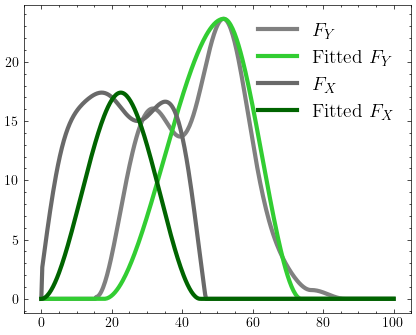

In [ ]:
# Initialize the dictionary for fitted profiles
fitted_profiles = {}

parametrization = "CubicHermiteSpline"

for profile_name, profile_df in profile_dict.items():
    # Remove .csv from the profile name
    profile_name = profile_name.replace(".csv", "")
    
    for force in ["force_X", "force_Y"]:  

        y = profile_df[force].values

        if force == "force_X":
            # Identify the non-zero region
            non_zero_indices = np.where(y >= 3)[0]
            if len(non_zero_indices) > 0:

                # Without max timing
                end_idx = non_zero_indices[-1]
                y_max = np.max(y[:end_idx + 1])
                params = [y_max, end_idx]
                # Construct the cubic Hermite spline
                grf, parametrization = f_prof_two(params)

                # With max timing
                # end_idx = non_zero_indices[-1]
                # y_max = np.max(y[:end_idx + 1])
                # max_idx = np.argmax(y[:end_idx + 1])
                # params = [max_idx, y_max, end_idx]
                # # Construct the cubic Hermite spline
                # grf, parametrization = f_prof_three(params)

                print(f"profile_{profile_name}_{force}_fmax_{y_max}_end_{end_idx}")

                curve = []
                for i in range(end_idx):
                    curve.append(grf.get_state(i)[0])

                # Pad the curve with zeros to match the full length of `result`
                padded_curve = np.concatenate([curve, np.zeros(len(y) - end_idx)])
            else:
                padded_curve = np.zeros_like(y)

        if force == "force_Y":
            # Identify the non-zero region
            non_zero_indices = np.where(y >= 3)[0]
            if len(non_zero_indices) > 0:
                # y/=2.7
                start_idx = non_zero_indices[0]
                end_idx = non_zero_indices[-1]
                y_max = np.max(y[start_idx:end_idx + 1])
                max_idx = np.argmax(y[start_idx:end_idx + 1])
                params = [0, max_idx, y_max, (end_idx-start_idx)]
                # Construct the cubic Hermite spline
                grf, parametrization = f_prof_four(params, (end_idx-start_idx))
                curve = []

                for i in range(end_idx-start_idx):
                    curve.append(grf.get_state(i)[0])
                
                # Pad the curve with zeros to match the full length of `result`
                padded_curve = np.concatenate([
                    np.zeros(start_idx),  # Zeros at the start
                    curve,                # Original curve
                    np.zeros(len(y) - end_idx)  # Zeros at the end
                ])

                print(f"profile_{profile_name}_{force}_fmax_{y_max}_start_{start_idx}_max_idx_{max_idx}_end_{end_idx}")

        fitted_profiles[f"{profile_name}_{force}_{parametrization}"] = padded_curve

if False:
    # Replace the actual profiles with the fitted ones
    for profile_name, profile_df in profile_dict.items():
        # Remove .csv from the profile name
        profile_name = profile_name.replace(".csv", "")
        for force in ["force_X", "force_Y"]:
            profile_df[force] = fitted_profiles[f"{profile_name}_{force}_{parametrization}"]

            # Save the modified dataframe
            profile_df.to_csv(f"{csv_path}/{profile_name}_fitted.csv", index=False)

    save_path = f"{csv_path}/plots"

forces = ["$F_X$", "$F_Y$"]
colors = ["dimgray", "gray"]
force_colors = ["darkgreen", "limegreen"]
alphas = [0.4, 1]

save_path = f"/Users/nathanirniger/Desktop/profiles"
if True:
    # Plot the orignial and fitted profiles
    for profile_name, profile_df in profile_dict.items():
        # Remove .csv from the profile name
        profile_name = profile_name.replace(".csv", "")
        print(profile_name)
        # for i, force in enumerate(["force_X", "force_Y"]):
        #     x = profile_df["Percentage"]
        #     y = profile_df[force]
        #     if max(y) > 3:
        #         plt.figure(figsize=(5, 4))
        #         plt.style.use('science')
        #         plt.plot(x, y, label=f"{forces[i]}", linewidth=3, color = colors[i])
        #         fitted_profile = fitted_profiles[f"{profile_name}_{force}_{parametrization}"]
        #         plt.plot(x, fitted_profile, label=f"Fitted {forces[i]}", linewidth=3, color = force_colors[i])
        #         plt.legend(fontsize=14)
        #         # plt.set_ylim(0, 65)
        #         plt.savefig(f"{save_path}/{profile_name}_{force}_{parametrization}.png")
                
        #         plt.show()

        # Plot the orignial and fitted profiles
        plt.figure(figsize=(5, 4))
        plt.style.use('science')
        plt.plot(profile_df["Percentage"], profile_df["force_Y"], label=f"$F_Y$", linewidth=3, color = "dimgray")
        fitted_profile = fitted_profiles[f"{profile_name}_force_Y_{parametrization}"]
        plt.plot(profile_df["Percentage"], fitted_profile, label=f"Fitted $F_Y$", linewidth=3, color = "darkgreen")
        plt.plot(profile_df["Percentage"], profile_df["force_X"], label=f"$F_X$", linewidth=3, color = "gray")
        fitted_profile = fitted_profiles[f"{profile_name}_force_X_{parametrization}"]
        plt.plot(profile_df["Percentage"], fitted_profile, label=f"Fitted $F_X$", linewidth=3, color = "limegreen")
        plt.legend(fontsize=14)
        # plt.set_ylim(0, 65)
        plt.savefig(f"{save_path}/{profile_name}_force_Y_{parametrization}.png")
        plt.show()

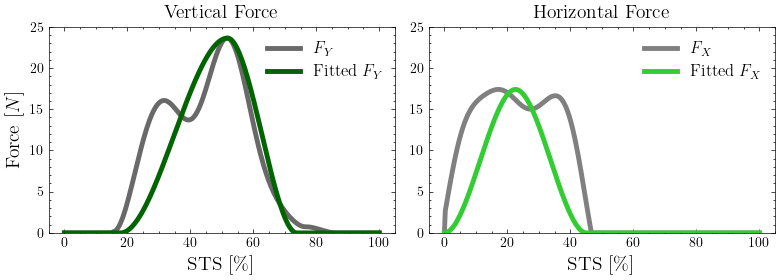

In [52]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Adjust width to fit both plots
plt.style.use('science')
fontsize = 14
linewidth = 3.5

# Left plot - Vertical Force (F_Y)
axes[0].plot(profile_df["Percentage"], profile_df["force_Y"], label=r"$F_Y$", linewidth=linewidth, color="dimgray")
fitted_profile_Y = fitted_profiles[f"{profile_name}_force_Y_{parametrization}"]
axes[0].plot(profile_df["Percentage"], fitted_profile_Y, label=r"Fitted $F_Y$", linewidth=linewidth, color="darkgreen")
axes[0].set_xlabel("STS $[\%]$", fontsize=fontsize)
axes[0].set_ylabel("Force $[N]$",fontsize=fontsize)
axes[0].set_ylim(0, 25)
axes[0].legend(fontsize=12)
axes[0].set_title("Vertical Force",fontsize=fontsize)

# Right plot - Horizontal Force (F_X)
axes[1].plot(profile_df["Percentage"], profile_df["force_X"], label=r"$F_X$", linewidth=linewidth, color="gray")
fitted_profile_X = fitted_profiles[f"{profile_name}_force_X_{parametrization}"]
axes[1].plot(profile_df["Percentage"], fitted_profile_X, label=r"Fitted $F_X$", linewidth=linewidth, color="limegreen")
axes[1].set_xlabel("STS $[\%]$",fontsize=fontsize)
# axes[1].set_ylabel("Horizontal Force $[N]$")
axes[1].set_ylim(0, 25)
axes[1].legend(fontsize=12)
axes[1].set_title("Horizontal Force",fontsize=fontsize)
# remove y ticks
# axes[1].set_yticks([])

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"{save_path}/{profile_name}_force_plots_{parametrization}.pdf" , format="pdf")

# Show the plots
plt.show()

In [ ]:
# Create zero force profile
profile_dict

profile = profile_dict["simulation_profile_Camille.csv"]

# replace all the forces with zeros
profile["force_X"] = 0
profile["force_Y"] = 0

profile.to_csv(f"zero_force_profile.csv", index=False)

In [ ]:
max_force = 65
max_time = 360

force1_end_time = 140.0
force1_peak_force = 18.0

force2_start_time = 84.0
force2_peak_time = 102.0
force2_end_time = 260.0
force2_peak_force = 60.0

# Revert to the original values (for the dynamic constraints)
force1_end_time_p = force1_end_time / max_time
force1_peak_force_p = force1_peak_force / (2/3 * max_force)

force2_peak_time_p = (force2_peak_time - 0.1 * max_time) / (0.8 * max_time)
force2_start_time_p = force2_start_time / force2_peak_time
force2_end_time_p = (force2_end_time - force2_peak_time) / (max_time - force2_peak_time)
force2_peak_force_p = force2_peak_force / max_force


print(f"force1_end_time_p: {force1_end_time_p}")
print(f"force1_peak_force_p: {force1_peak_force_p}")
print(f"force2_peak_time_p: {force2_peak_time_p}")
print(f"force2_start_time_p: {force2_start_time_p}")
print(f"force2_end_time_p: {force2_end_time_p}")
print(f"force2_peak_force_p: {force2_peak_force_p}")

force1_end_time_p: 0.3888888888888889
force1_peak_force_p: 0.4153846153846154
force2_peak_time_p: 0.22916666666666666
force2_start_time_p: 0.8235294117647058
force2_end_time_p: 0.6124031007751938
force2_peak_force_p: 0.9230769230769231
